In [11]:
import numpy as np
import cv2
import os
from PIL import Image
import math
import scipy as sp

# **Alignment**

### Functions

In [12]:
#Band Limited Phase-Only Correlation (BLPOC) function
def BLPOC(inp_img,reg_img,k1,k2):
  factor=0.8
  #k1 and k2 are less than M1 (rows) and M2 (columns). The factor simply scales k1 and k2 to be less than M1 and M2
  rows,columns=reg_img.shape
  k1=int(rows*factor)
  k2=int(columns*factor)


  #Performing the fft shift on the input image
  inp_img_fftshift= np.fft.fftshift(np.fft.fft2(inp_img))
  #Performing the fft shift on the registered image
  reg_img_fftshift= np.fft.fftshift(np.fft.fft2(reg_img))
  nrow,ncol=(np.fft.fft2(inp_img)).shape

  #Taking the conjugate of the input for subsequent usage in the cross phase spectrum
  inp_fft_conjugate=np.matrix.conjugate(inp_img_fftshift)

  #Calculating the cross phase spectrum
  cross_phase_spectrum= np.divide(np.multiply(reg_img_fftshift,inp_fft_conjugate),np.abs(np.multiply(reg_img_fftshift,inp_fft_conjugate)))

  #Creating the BLPOC matrix
  #Can change if it does not work directly
  m1=(int)(rows/2)
  m2=(int)(columns/2)
  blpoc=np.zeros((2*k1+1,2*k2+1),dtype=complex)
  blpoc=cross_phase_spectrum[(m1-k1):(m1+k1),(m2-k2):(m2+k2)]

  #Inverse Fourier Transform of BLPOC
  blpoc_ifft=np.abs(np.fft.ifft2(np.fft.ifftshift(blpoc)))

  #Calculating the peak value using the average of the top 2 peak values
  peak_val1=np.amax(blpoc_ifft)
  peak_val2=np.partition(blpoc_ifft.flatten(),-2)[-2]
  peak_val_final=(peak_val1+peak_val2)/2

  return peak_val_final



In [13]:
#Core Alignment: Displacement
def core_alignment_disp(inp_core,reg_core,inp_path,reg_path):
  inp_img=cv2.imread(inp_path,0)
  reg_img=cv2.imread(reg_path,0)
  rows,columns=reg_img.shape

  #Initializing the image after applying the affine transformation on the registered image
  transformed_reg_arr=np.zeros((rows,columns))

  #Printing the coordinates of both the input image and the registered image
  print("Registered Image Coordinates:",str(reg_core))
  print("Input Image Coordinates:",str(inp_core))

  #Calculating the displacements in the x and y directions
  translation_x=inp_core[0]-reg_core[0]
  translation_y=inp_core[1]-reg_core[1]

  #Initializing the affine transformation matrix
  affine_transformation=np.float32([[1,0,translation_x],[0,1,translation_y]])

  #Calculating the final registered image after applying the transformation
  transformed_reg_arr=cv2.warpAffine(reg_img,affine_transformation,(columns,rows))
  transfomed_reg_img=Image.fromarray(transformed_reg_arr)

  #transformed_reg_img.show()
  #Can show the image
  print("Core alignment done")
  return transformed_reg_arr


In [14]:
#Image Rotation and best BLPOC calculation
def img_rotate_blpoc(num_rot,inp_img_path,disp_reg_img,inp_core,k1,k2):

  #Initializing the maximum blpoc to -1000, initial rotation angle to -40 degrees and maximum blpoc yielding angle to -40 degrees
  blpoc_max=-1000
  initial_angle=-40
  max_blpoc_angle=-40
  rows,columns=disp_reg_img.shape
  inp_img=cv2.imread(inp_img_path,0)

  for i in range(0,num_rot+1):
    #Obtaining the rotation matrix and performing the rotation on the displaced registered image
    rot_angle=initial_angle+i
    rot_transformation=cv2.getRotationMatrix2D((inp_core[0],inp_core[1]),rot_angle,1)
    rot_img=cv2.warpAffine(disp_reg_img,rot_transformation,(columns,rows))
    img=Image.fromarray(rot_img)
    #Can show the image
    #img.show()

    #Checking if the transformed image has the maximum BLPOC
    blpoc_val=BLPOC(inp_img,rot_img,k1,k2)
    if(blpoc_max<blpoc_val):
      blpoc_max=blpoc_val
      max_blpoc_angle=rot_angle

  #Can print the angle pertaining to the maximum BLPOC
  #print(max_blpoc_angle)

  rot_transformation=cv2.getRotationMatrix2D((inp_core[0],inp_core[1]),max_blpoc_angle,1)
  final_rot_img=cv2.warpAffine(disp_reg_img,rot_transformation,(columns,rows))
  img=Image.fromarray(final_rot_img)
  print("Maximum BLPOC verification and rotation completed")
  return final_rot_img
'''
def main():
  input_image_path="Input Image.tif"
  reg_image_path="Registered Image.tif"
  img_rotate_blpoc(80,input_image_path,reg_image_path)

if __name__=='__main__':
  main()
  '''

'\ndef main():\n  input_image_path="Input Image.tif"\n  reg_image_path="Registered Image.tif"\n  img_rotate_blpoc(80,input_image_path,reg_image_path)\n\nif __name__==\'__main__\':\n  main()\n  '

In [15]:
#POC calculation on rotation
def poc_align():
  #Change paths and file names as and when required
  inp_img=cv2.imread("Input Image.tif",0)
  reg_rotated_im=cv2.imread("Rotated Image.tif",0)
  reg_img_arr=np.asarray(reg_rotated_im)
  rows,columns=reg_rotated_im.shape

  #POC computation
  rot_img_fftshift=np.fft.fftshift(np.fft.fft2(reg_rotated_im))
  inp_img_fftshift=np.fftshift(np.fft.fft2(inp_img))
  inp_fft_conjugate=np.matrix.conjugate(inp_img_fftshift)

  cross_phase_spectrum=np.divide(np.multiply(inp_fft_conjugate,rot_img_fftshift),np.abs(np.multiply(inp_fft_conjugate,rot_img_fftshift)))
  poc=np.abs(np.fft.ifft2(np.fftshift(cross_phase_spectrum)))

  i,j=np.unravel_index(poc.argmax(),poc.shape)
  x_disp=j-columns/2
  y_disp=i-rows/2
  print("The translational displacements are:",[x_disp,y_disp])
  p=np.amax(poc)
  print("Maximum value is:",p)

  transformation=np.float32([[1,0,x_disp],[0,1,y_disp]])
  inp_displaced=cv2.warpAffine(reg_rotated_im,transformation,(rows,columns))


In [16]:
def segment(rotated_img,scale):
  rotated_img=(rotated_img-np.amin(rotated_img))/(np.amax(rotated_img)-np.amin(rotated_img))
  rotated_row_sum=rotated_img.sum(axis=1)
  rotated_col_sum=rotated_img.sum(axis=0)
  rotated_row_sum=np.reshape(rotated_row_sum,(rotated_row_sum.shape[0],1))
  rotated_col_sum=np.reshape(rotated_col_sum,(rotated_col_sum.shape[0],1))
  rows,columns=rotated_img.shape
  top_row=0
  bottom_row=rows
  left_col=0
  right_col=columns
  for i in range(0,rows):
    if(rotated_row_sum[i][0]>columns*scale):
      top_row=i
      break
  for i in range(1,rows-1):
    if(rotated_row_sum[rows-i][0]>columns*scale):
      bottom_row=rows-i
      break
  for i in range(0,columns):
    if(rotated_col_sum[i][0]>rows*scale):
      left_col=i
      break
  for i in range(1,columns-1):
    if(rotated_col_sum[columns-i][0]>rows*scale):
      right_col=rows-i
      break
  return top_row,bottom_row,left_col,right_col


In [17]:
def remap_relabel(rotated_image,rotation,center_coord_0,center_coord_1):
  M_inv=cv2.getRotationMatrix2D((center_coord_0,center_coord_1),-1*rotation,1)
  #print M_inv
  rows,columns=rotated_image.shape
  #print rows
  for i in range(0,rows):
    for j in range(0,columns):
      new_coord_col=j-center_coord_1
      new_coord_row=i-center_coord_0
      point=[i,j]
      #print point
      point=np.asarray(point)
      point=np.reshape(point,(2,1))
      original_pt=cv2.transform(point,M_inv)
      #print original_pt
      if(original_pt[0]<0 or original_pt[0]>rows or original_pt[1]<0 or original_pt[1]>columns):
        rotated_image[i,j]=-1
    return rotated_image

### Main Alignment Code

C:\Users\Raavi_Gupta\AppData\Local\Temp\ipykernel_17120\1212310666.py:4: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  database=np.load("D:/Academics_4th_year/7th_sem/CS663/biometrics/cores_4_1234.npy")
  0%|          | 0/20 [00:00<?, ?it/s]

Registered Image Coordinates: [160. 176.]
Input Image Coordinates: [96. 96.]
Core alignment done


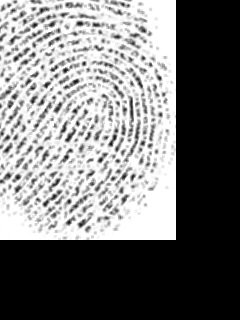

Displaced Registered Image
Maximum BLPOC verification and rotation completed


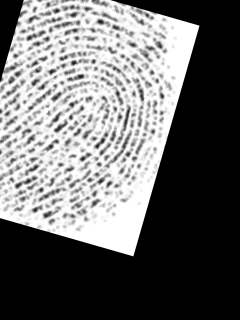

Rotated Image


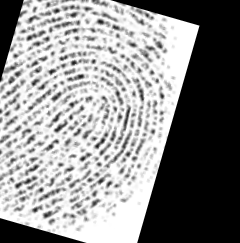

Segmented Registered Image


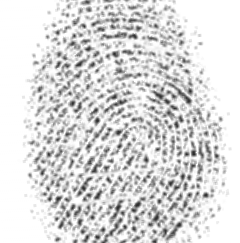

  0%|          | 0/20 [00:00<?, ?it/s]

Segmented Input Image
101 101
0.025


In [27]:
#Ongoing
from tqdm import tqdm
import numpy as np
database=np.load("D:/Academics_4th_year/7th_sem/CS663/biometrics/cores_4_1234.npy")
num_rot=100
scale=0.2
k1=150
k2=150
k1_1=100
k2_1=100
num_test=2
num_subjects=10
num_img_sub=4
var=0
k=0
inp_path=0
data_path_reg="DB4_B_one_to_four"
data_path_ip="DB4_B_five_to_eight"
num_arr=["101_","102_","103_","104_","105_","106_","107_","108_","109_","110_"]
# c=0
test_img_arr=[]
for i in num_arr:
	for j in range(5,9):
		test_img_arr.append(i+str(j)+".tif")
#print(test_img_arr)
count=0
for test_im in test_img_arr[:1]:
	k = 0		
	test_iter=6
	images=os.listdir(data_path_reg)
	#print(len(images))
	blpoc_max=-100
	best_img=0

	train_path = list()
	train_cores = np.zeros(((num_img_sub-num_test)*num_subjects, 2))
	for i in range(0,num_subjects):
		for j in range(0,(num_img_sub-num_test)) :
			#print i*(num_img_sub-num_test) + j + i*num_test
			train_cores[var][0] = database[i*(num_img_sub-num_test) + j + i*num_test][0]
			train_cores[var][1] = database[i*(num_img_sub-num_test) + j + i*num_test][1]
			train_path.append(images[i*(num_img_sub-num_test) + j + i*num_test])
			var = var + 1
	train_path = np.asarray(train_path)
	var = 0
	for i in tqdm(train_path):
		# print(k)
		reg_img_path = os.path.join(data_path_reg, i)
		input_img_path = os.path.join(data_path_ip, test_im)
		reg_coord = np.zeros((2, 1))
		input_coord = np.zeros((2, 1))
		reg_coord = train_cores[k, :]
		input_coord = database[test_iter, :]
		k = k + 1
		input_img = cv2.imread(input_img_path, 0)
		displaced_reg = core_alignment_disp(input_coord, reg_coord, input_img_path, reg_img_path)
		displaced_reg_img = Image.fromarray(displaced_reg)
		display(displaced_reg_img)
		print ('Displaced Registered Image')
		rot_reg_img = img_rotate_blpoc(num_rot, input_img_path, displaced_reg, input_coord, k1, k2)
	#Some error here...data uploading related
		rot_img = Image.fromarray(rot_reg_img)
		#rot_img.show()
		display(rot_img)
		print ('Rotated Image')
		top_row, bottom_row, left_col, right_col = segment(rot_reg_img, scale)
		new_reg = np.zeros((bottom_row - top_row + 1, right_col - left_col + 1))
		new_input = np.zeros((bottom_row - top_row + 1, right_col - left_col + 1))
		new_reg = rot_reg_img[top_row:bottom_row, left_col:right_col]
		new_input = input_img[top_row:bottom_row, left_col:right_col]
		reg_segmented = Image.fromarray(new_reg)
		input_segmented = Image.fromarray(new_input)
		display(reg_segmented)
		print('Segmented Registered Image')
		display(input_segmented)
		print('Segmented Input Image')

		#print (new_input.shape)
		#print (new_reg.shape)


		blpoc_val = BLPOC(new_input, new_reg, k1_1, k2_1)
		if (blpoc_val > blpoc_max) :
			blpoc_max = blpoc_val
			best_img = i
			inp_path=input_img_path
			break
	#print (blpoc_max)
	#print ('Path of the image yielding the maximum matching score:',inp_path)
	print(test_im[:3], inp_path[-9:-6])
	if(inp_path[-9:-6]==test_im[:3]):
		count+=1
print(count/40)
		


	# print reg_img_path

